In [1]:
# Install necessary packages
!pip install kaggle
import os # System and file handling
import json
import zipfile
import numpy as np # Numerical and data manipulation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns
import tensorflow as tf # Machine Learning / Deep Learning
from tensorflow.keras import models, layers
from sklearn.metrics import classification_report, confusion_matrix



In [2]:

# Load Kaggle credentials from the saved JSON file
with open('kaggle.json') as file:
    kaggle_credentials = json.load(file)

# Set Kaggle username and key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']


In [3]:
# Downloading the dataset from kaggle
!kaggle datasets download -d apollo2506/eurosat-dataset


Dataset URL: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
License(s): CC0-1.0
100% 2.04G/2.04G [00:14<00:00, 234MB/s]
100% 2.04G/2.04G [00:14<00:00, 155MB/s]


In [4]:

# Define zip path and extract path
zip_path = "/content/eurosat-dataset.zip"
extract_path = "/content/eurosat"

In [5]:
# Extract zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Dataset unzipped successfully.")

 Dataset unzipped successfully.


In [6]:
# Checking what folders/files are inside the dataset
for root, dirs, files in os.walk("/content/eurosat"):
    print("Folder:", root)
    print("Subfolders:", dirs)
    print("Files:", files[:5])
    break


Folder: /content/eurosat
Subfolders: ['EuroSAT', 'EuroSATallBands']
Files: []


In [7]:
#Load images using TensorFlow's image_dataset_from_directory


data_dir = "/content/eurosat/EuroSAT"

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(64, 64),
    batch_size=32,
    shuffle=True,
    seed=42
)

class_names = dataset.class_names
print("Classes in the dataset:", class_names)



Found 27000 files belonging to 10 classes.
Classes in the dataset: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


**I found that there are 27000 images which is associated with 10 different classes which are  'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'**

**EDA**

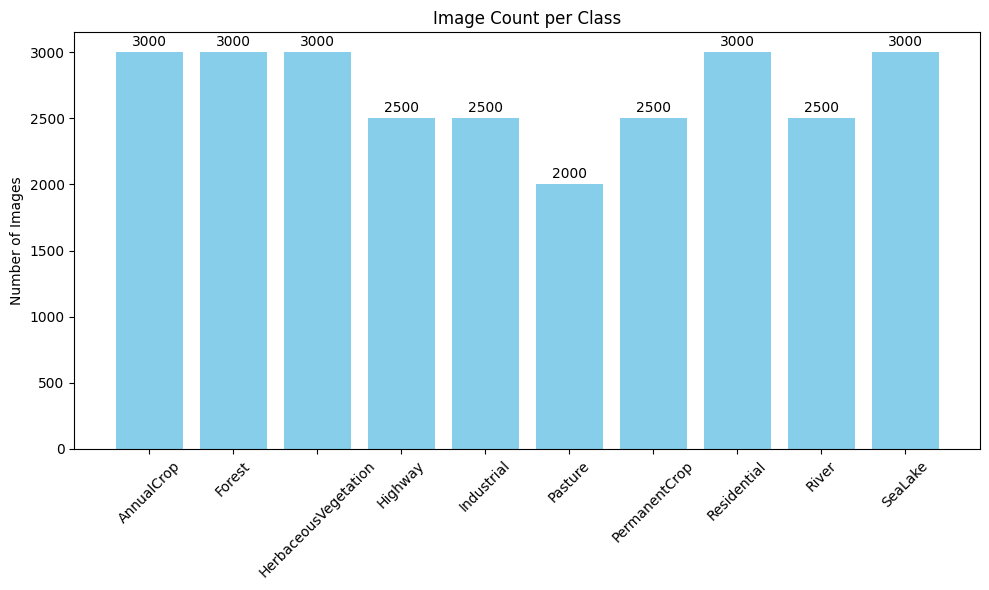

In [8]:
#Visualizing the number of images in each class


class_counts = {}
for class_name in class_names:
    folder = os.path.join(data_dir, class_name)
    class_counts[class_name] = len(os.listdir(folder))

plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title("Image Count per Class")
plt.ylabel("Number of Images")

# Add values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center')

plt.tight_layout()
plt.show()


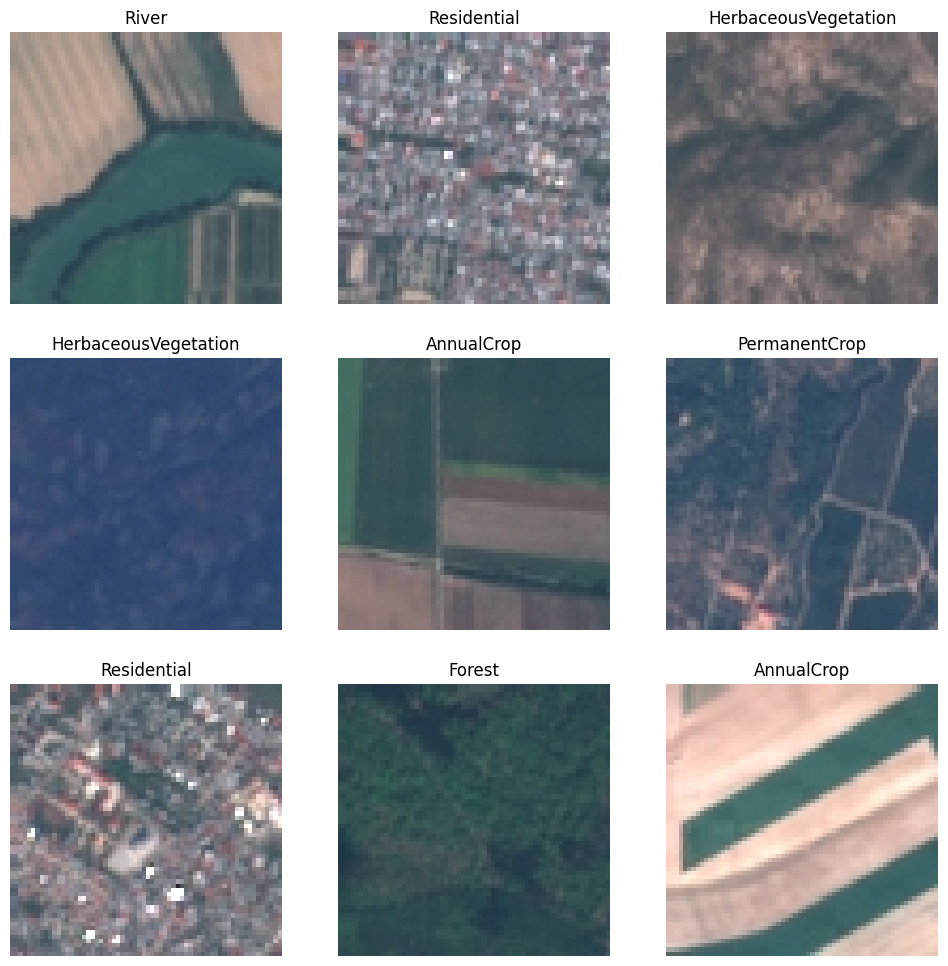

In [9]:
#  Displaying some random images from the dataset
plt.figure(figsize=(12, 12))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis("off")


In [10]:
#now we are plitting the dataset into training, validation and test sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(64, 64),
    batch_size=32,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(64, 64),
    batch_size=32,
    label_mode="categorical"
)

# Splitting the val_ds to get a test set
test_batches = val_ds.cardinality() // 2
test_ds = val_ds.take(test_batches)
val_ds = val_ds.skip(test_batches)

print("Train batches:", train_ds.cardinality().numpy())
print("Val batches:", val_ds.cardinality().numpy())
print("Test batches:", test_ds.cardinality().numpy())


Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.
Train batches: 675
Val batches: 85
Test batches: 84


In [11]:
#  improving the  performance using prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [12]:
# Adding data augmentation to improve generalization


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])



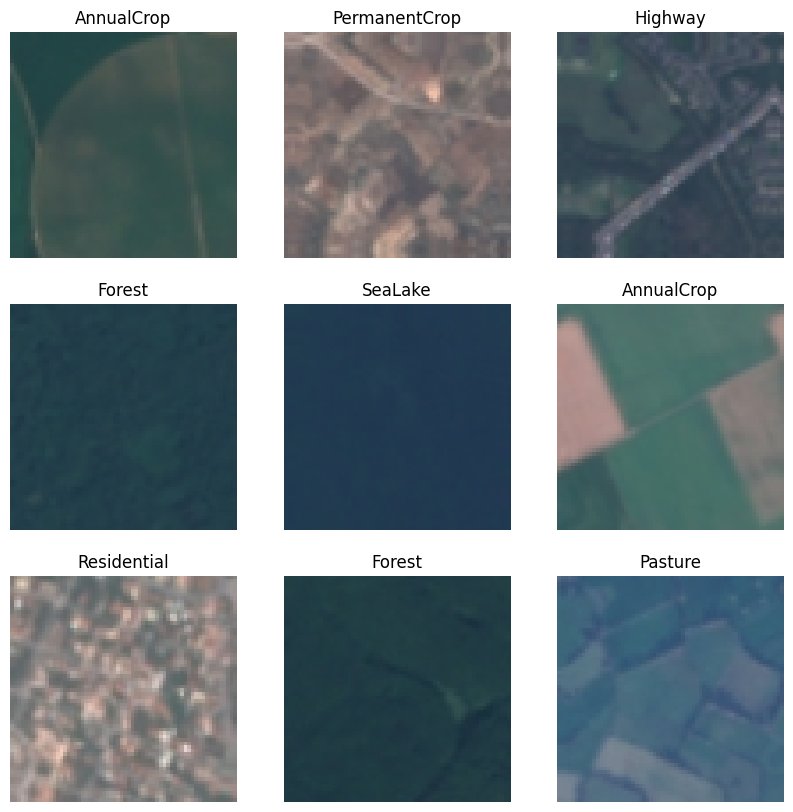

In [13]:
#  Showing augmented images with class names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_img = data_augmentation(images[i])
        label = class_names[tf.argmax(labels[i])]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_img.numpy().astype("uint8"))
        plt.title(label)
        plt.axis("off")



-----------------------Building a custom CNN model or base model (sequential)









In [14]:

#  CNN model
model = models.Sequential([
    # Input shape is defined here in the first layer
    layers.Rescaling(1./255, input_shape=(64, 64, 3)),

    # Data augmentation
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),

    # Conv block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Conv block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Conv block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Fully connected layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model structure
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,490 (2.61 MB)

 Trainable params: 684,490 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

---------------------------------------------- **training the model**-------------------------------

In [15]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.3329 - loss: 1.7395 - val_accuracy: 0.5859 - val_loss: 1.1299
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5998 - loss: 1.1007 - val_accuracy: 0.6261 - val_loss: 1.0287
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.6579 - loss: 0.9459 - val_accuracy: 0.6397 - val_loss: 0.9945
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.7070 - loss: 0.8176 - val_accuracy: 0.6423 - val_loss: 1.0100
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7319 - loss: 0.7494 - val_accuracy: 0.7400 - val_loss: 0.7076
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7542 - loss: 0.6963 - val_accuracy: 0.7301 - val_loss: 0.7403
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7639 - loss: 0.6712 - val_accuracy: 0.7810 - val_loss: 0.5945
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7857 - loss: 0.6047 - val_

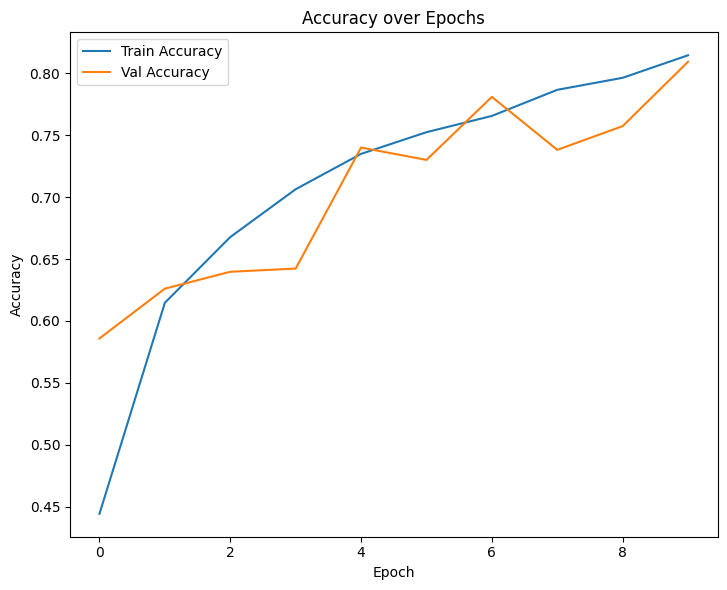

In [16]:
#Visualize training progress

# Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


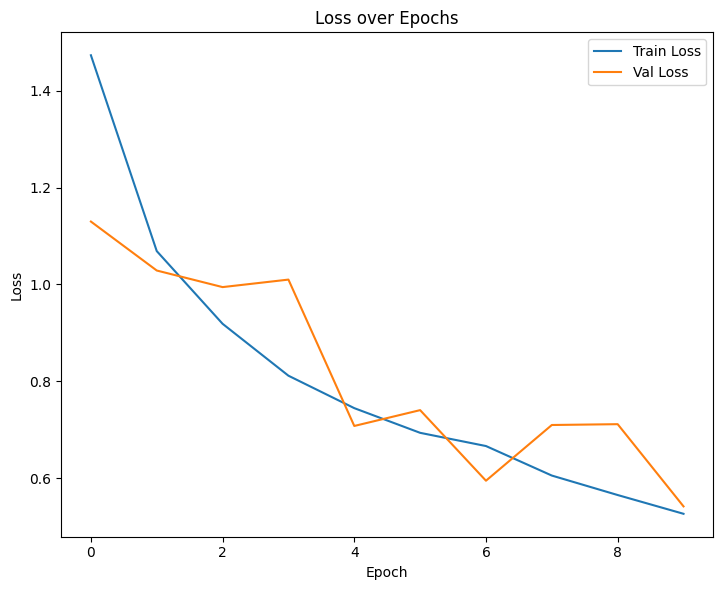

In [17]:
# Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [18]:

#  Get predictions and true labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Use previously saved class_names
class_labels = class_names  # You got this from dataset.class_names earlier



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

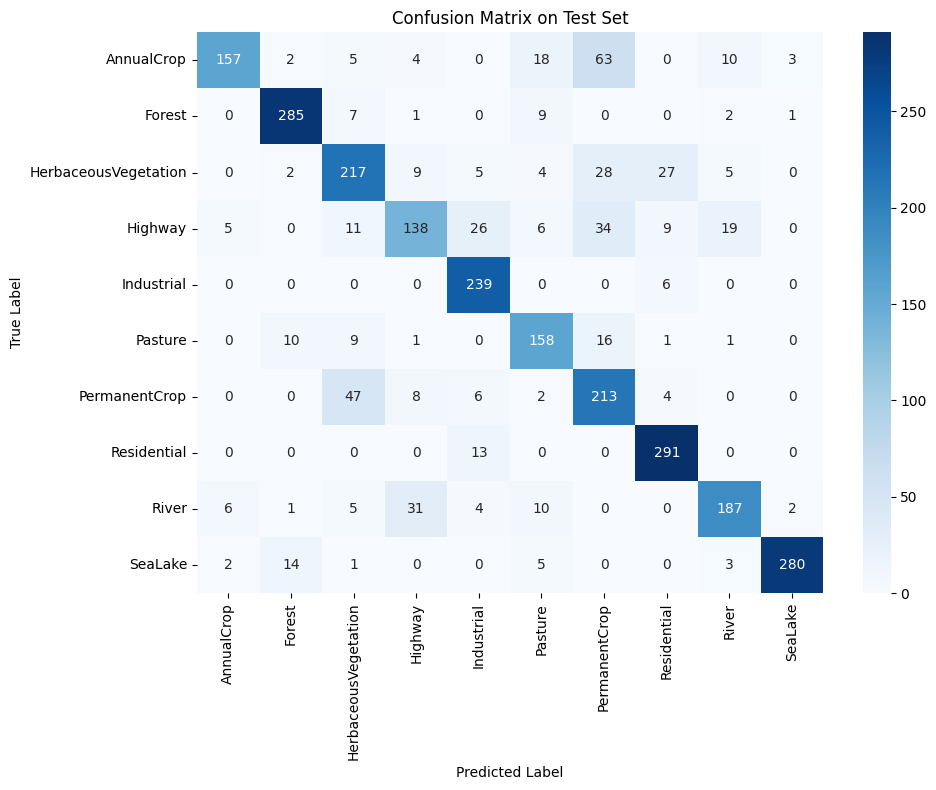

In [19]:

#  Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()



A few observations:
River and PermanentCrop have more misclassifications.

Some confusion between HerbaceousVegetation ↔ PermanentCrop, which makes sense visually (they can look similar in satellite imagery).

In [20]:
#  Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.92      0.60      0.73       262
              Forest       0.91      0.93      0.92       305
HerbaceousVegetation       0.72      0.73      0.72       297
             Highway       0.72      0.56      0.63       248
          Industrial       0.82      0.98      0.89       245
             Pasture       0.75      0.81      0.77       196
       PermanentCrop       0.60      0.76      0.67       280
         Residential       0.86      0.96      0.91       304
               River       0.82      0.76      0.79       246
             SeaLake       0.98      0.92      0.95       305

            accuracy                           0.81      2688
           macro avg       0.81      0.80      0.80      2688
        weighted avg       0.81      0.81      0.80      2688



In [27]:
from google.colab import files
uploaded = files.upload()


Saving River_1.jpg to River_1 (1).jpg


In [30]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Replace 'your_image.jpg' with the actual filename you uploaded
img_path = list(uploaded.keys())[0]  # Automatically gets the uploaded file
img = image.load_img('/content/River_1.jpg', target_size=(64, 64))  # Match your model input size
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize like training data
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


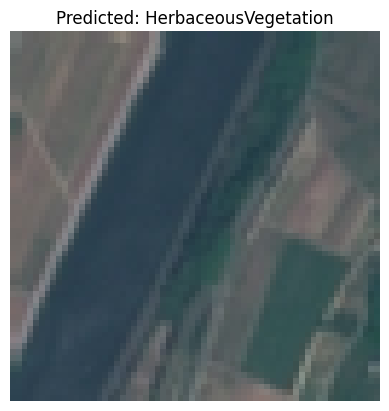

In [31]:
# Make prediction
prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction)]

# Display image with predicted label
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()

In [32]:
from tensorflow.keras import models, layers, callbacks

# Building a better CNN model
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(64, 64, 3)),

    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:

# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint]  # only saving best model
)



Epoch 1/20
668/675 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5166 - loss: 1.7228

675/675 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.5174 - loss: 1.7178 - val_accuracy: 0.2032 - val_loss: 10.2592
Epoch 2/20
674/675 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6733 - loss: 0.9343

675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.6733 - loss: 0.9341 - val_accuracy: 0.4738 - val_loss: 3.1891
Epoch 3/20
670/675 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7426 - loss: 0.7672

675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7427 - loss: 0.7669 - val_accuracy: 0.6493 - val_loss: 1.0926
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7903 - loss: 0.6356 - val_accuracy: 0.4867 - val_loss: 2.2767
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8270 - loss: 0.5370 - val_accuracy: 0.4864 - val_loss: 2.2939
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8515 - loss: 0.4690 - val_accuracy: 0.4882 - val_loss: 2.6338
Epoch 7/20
672/675 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8674 - loss: 0.4023

675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8675 - loss: 0.4023 - val_accuracy: 0.7028 - val_loss: 1.0721
Epoch 8/20
669/675 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8761 - loss: 0.3886

675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8762 - loss: 0.3884 - val_accuracy: 0.7596 - val_loss: 0.8693
Epoch 9/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8961 - loss: 0.3387 - val_accuracy: 0.7507 - val_loss: 2.2123
Epoch 10/20
668/675 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9066 - loss: 0.2846

675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9067 - loss: 0.2845 - val_accuracy: 0.8654 - val_loss: 0.4864
Epoch 11/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9149 - loss: 0.2759 - val_accuracy: 0.7876 - val_loss: 0.9619
Epoch 12/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9212 - loss: 0.2528 - val_accuracy: 0.5863 - val_loss: 3.4351
Epoch 13/20
674/675 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9285 - loss: 0.2236

675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9285 - loss: 0.2236 - val_accuracy: 0.9097 - val_loss: 0.2901
Epoch 14/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9341 - loss: 0.2091 - val_accuracy: 0.8643 - val_loss: 0.5694
Epoch 15/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9477 - loss: 0.1631 - val_accuracy: 0.7703 - val_loss: 0.9238
Epoch 16/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9520 - loss: 0.1500 - val_accuracy: 0.8816 - val_loss: 0.4253
Epoch 17/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9444 - loss: 0.1849 - val_accuracy: 0.8005 - val_loss: 1.0351
Epoch 18/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9523 - loss: 0.1564 - val_accuracy: 0.6726 - val_loss: 1.5443
Epoch 19/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9597 - loss: 0.1296 - val_accuracy: 0.7740 - val_loss: 0.9644
Epoch 20/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9611 - loss: 0.1277 - val_accurac

In [36]:
from google.colab import files

# Upload a new image again
uploaded = files.upload()

# Then this will work
img_path = list(uploaded.keys())[0]

Saving River_1.jpg to River_1 (2).jpg


In [39]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Get filename automatically
img_path = list(uploaded.keys())[0]

# Load and resize the image to match model input
img = image.load_img('/content/River_1 (2).jpg', target_size=(64, 64))
img_array = image.img_to_array(img)

# Normalize and expand dimensions
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


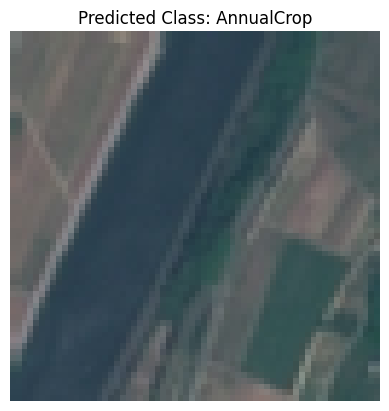

In [40]:
# Predict the class
prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction)]

# Display the image and result
plt.imshow(img)
plt.title(f"Predicted Class: {predicted_class}")
plt.axis("off")
plt.show()


In [41]:
# Print all class probabilities
for i, prob in enumerate(prediction[0]):
    print(f"{class_names[i]}: {prob:.4f}")


AnnualCrop: 1.0000
Forest: 0.0000
HerbaceousVegetation: 0.0000
Highway: 0.0000
Industrial: 0.0000
Pasture: 0.0000
PermanentCrop: 0.0000
Residential: 0.0000
River: 0.0000
SeaLake: 0.0000
